In [4]:
%matplotlib inline
import sys
sys.path.insert(0, '../src')
import glob
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import os

from random import choices
from scipy import stats
from analyze import test
from geospatial import *
from eda import *

from pylab import rcParams
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

In [2]:
crimes = pd.read_csv('../data/cleaned/crime-processed.csv')
arrests = pd.read_csv('../data/cleaned/arrests-processed.csv')

In [ ]:
census = read_gis()

In [ ]:
census.rename(columns=CENSUS_MAP, inplace=True)

In [ ]:
for col in census:
    if col.startswith('H7'):
        census.drop(col, axis=1, inplace=True)
census['Other'] += census['Others']

In [ ]:
census_div = census[['APREC', 'Total', 'White', 'Black or African American',
       'American Indian and Alaska Native', 'Asian',
       'Native Hawaiian and Other Pacific Islander', 'Other',
       'Hispanic or Latino']]

In [ ]:
census_div = census_div.groupby('APREC').sum()

In [ ]:
census_div

In [ ]:
census_div.div(census_div['Total'], axis=0)

In [ ]:
predpol_2013 = census_div.loc[['FOOTHILL', 'SOUTHEAST', 'NORTH HOLLYWOOD']].sum().to_frame().T
predpol_2013.div(predpol_2013['Total'], axis=0)

# Crime & Arrest Trends

In [ ]:
crimes['Date Rptd'] = pd.to_datetime(crimes['Date Rptd'])

In [ ]:
daily_crimes = crimes.loc[crimes.Year!=2020].groupby('Date Rptd').size()

In [ ]:
fig = plt.figure(figsize=(10, 6))
ax = daily_crimes.plot(legend=False)
ax.set_title('Crime Trends in LA (2010-2019)', fontsize=25)
daily_crimes.rolling(window=7).mean().plot(ax=ax)
daily_crimes.rolling(window=30).mean().plot(ax=ax)
daily_crimes.rolling(window=365).mean().plot(ax=ax)
plt.axvline(dt.datetime(2013, 1, 1), linewidth=3, color='purple')
plt.axvline(dt.datetime(2015, 1, 1), linewidth=3, color='yellow')
ax.legend(['Daily', 'Weekly', 'Monthly', 'Annually', 'PredPol in 3 Divisions', 'PredPol in All Divisions'])
plt.savefig('Crime Trends in LA (2010-2019)', bbox_inches='tight')
plt.show()

In [ ]:
filtered_crimes = crimes.loc[(crimes.Year>=2013)&(crimes.Year<=2014)].groupby('Date Rptd').size()
fig = plt.figure(figsize=(10, 6))
ax = filtered_crimes.plot(legend=False)
ax.set_title('Crime Trends in LA (2013-2014)')
filtered_crimes.rolling(window=7).mean().plot(ax=ax)
filtered_crimes.rolling(window=30).mean().plot(ax=ax)
ax.legend(['Daily', 'Weekly', 'Monthly'])
plt.show()

# Stationarity of Time Series

In [ ]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, title):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title(title)
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

### Overall crimes is stationary i.e. mean and variance does not vary over time

In [ ]:
test_stationarity(daily_crimes, 'Daily Crimes 2010-2019')

### Crimes between 2013-14 isn't stationary - slightly decreasing

In [ ]:
test_stationarity(filtered_crimes, 'Daily Crimes 2013-14')

### Crimes after PredPol was deployed in all divisions were stationary once again with higher mean compared to pre-2013

In [ ]:
test_stationarity(crimes.loc[(crimes.Year<=2012)&(crimes.Year!=2020)].groupby('Date Rptd').size(),'Daily Crimes pre-2013')

In [ ]:
test_stationarity(crimes.loc[(crimes.Year>=2015)&(crimes.Year!=2020)].groupby('Date Rptd').size(),'Daily Crimes post-2015')

In [ ]:
arrests['Arrest Date'] = pd.to_datetime(arrests['Arrest Date'])
d1aily_arrests = arrests.loc[arrests.Year!=2020].groupby('Arrest Date').size()
fig = plt.figure(figsize=(10, 6))
ax = daily_arrests.plot(legend=False)
ax.set_title('Arrest Trends in LA (2010-2019)')
daily_arrests.rolling(window=7).mean().plot(ax=ax)
daily_arrests.rolling(window=30).mean().plot(ax=ax)
daily_arrests.rolling(window=365).mean().plot(ax=ax)
ax.legend(['Daily', 'Weekly', 'Monthly', 'Annually'])
plt.axvline(dt.datetime(2013, 1, 1), linewidth=3, color='purple')
plt.axvline(dt.datetime(2015, 1, 1), linewidth=3, color='yellow')
ax.legend(['Daily', 'Weekly', 'Monthly', 'Annually', 'PredPol in 3 Divisions', 'PredPol in All Divisions'])
plt.show()

In [ ]:
filtered_arrests = arrests.loc[(arrests.Year>=2013)&(arrests.Year<=2014)].groupby('Arrest Date').size()
fig = plt.figure(figsize=(10, 6))
ax = filtered_arrests.plot(legend=False)
ax.set_title('Arrest Trends in LA (2013-2014)')
filtered_arrests.rolling(window=7).mean().plot(ax=ax)
filtered_arrests.rolling(window=30).mean().plot(ax=ax)
ax.legend(['Daily', 'Weekly', 'Monthly'])
plt.show()

In [ ]:
test_stationarity(filtered_arrests, 'Daily Arrests 2013-2014')

# Distribution of Crime Types

### Here we narrow our scope to just data between 2013 and 2014 when PredPol was only deployed in the North Hollywood, Southeast, and Foothill divisions
### The t-tests thus compare the distribution of crime types in those divisions with the distribution of the remaining 18 divisions

In [ ]:
from analyze import *

In [ ]:
def format_df(df, feat, scope=False, area=False, group='PredPol Deployed', group2=['Area Name', 'PredPol Deployed']):
    if feat == 'Descent Description':
        group = 'Reassigned Officer'
        group2 = ['Stop Division', 'Reassigned Officer']
    if scope:
        df = df.loc[(df.Year >= 2013) & (df.Year <= 2014)]
    else:
        df = df.loc[df.Year != 2020]
    if not area:
        return df.groupby(group)[feat].value_counts(normalize=True).unstack().T
    else:
        return df.groupby(group2)[feat].value_counts(normalize=True).unstack()

format_df(crimes, 'Crime Type', scope=True)

In [ ]:
def test_overall(df, outpath, feat, scope=False):
    print('Testing overall distribution of {}.'.format(feat))
    types = format_df(df, scope=scope, feat=feat)
    statvals = []
    pvals = []
    for tp, row in types.iterrows():
        print('{}: {}'.format(feat, tp))
        try:
            stat, pval = test(tp, row[1], row[0])
        except IndexError:
            stat, pval = 0.0, 0.0
        statvals.append(round(stat, 5))
        pvals.append(round(pval, 5))
        print('Statistic = ', stat)
        print('P-Value = {}\n'.format(pval))
    if feat == 'Crime Type' or feat == 'Charge Group Description':
        idx = TYPES
    elif feat == 'Crime Charge' or feat == 'Arrest Type Code':
        idx = CHARGES
    elif feat == 'Descent Description':
        idx = RACES
    if scope:
        title = 'ovr_{}_dist_2013-14.csv'.format(feat)
    else:
        title = 'ovr_{}_dist.csv'.format(feat)
    try:
        pd.DataFrame({'Statistic':statvals, 'P-Value':pvals}, index=idx).to_csv(os.path.join(outpath, title))
    except ValueError:
        pd.DataFrame({'Statistic':statvals, 'P-Value':pvals}, index=idx[:-1]).to_csv(os.path.join(outpath, title))
    print('Complete.')

test_overall(crimes, '', 'Crime Type', scope=True)

In [ ]:
format_df(arrests, 'Charge Group Description', scope=True)

In [ ]:
test_overall(arrests, '', 'Charge Group Description', scope=True)

Plotting Number of Arrests by Year
Complete.


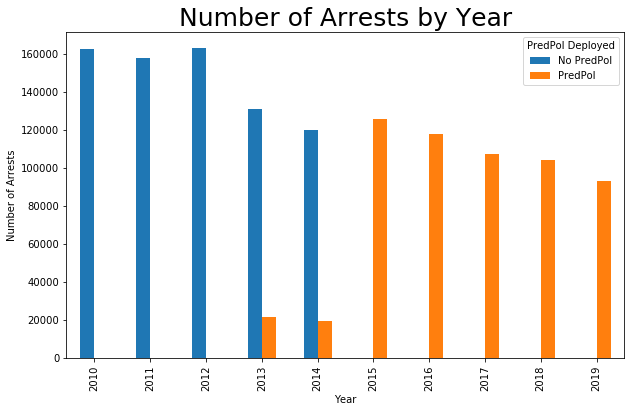

In [5]:
plot_graph(group_df(arrests, ['PredPol Deployed','Year'], 'size'), '', 'bar', 'Number of Arrests by Year', 'Year', 'Number of Arrests')